<center><h1>Projet Robotique</h1></center>
<center><h2>Classification via LSTM</h2></center>

# Importation des librairies

In [1]:
!pip install bayesian-optimization

In [2]:
import os
from google.colab import drive

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from bayes_opt import BayesianOptimization

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras.optimizers import Adam
from keras.api._v2.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')
# disable tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Configaration GPU

In [3]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
  print("Found GPU at:{}".format(device_name))
else:
  device_name="/device:CPU:0"
  print("No GPU")

Found GPU at:/device:GPU:0


# Importation du dataset

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/MyDrive/Robotique/preprocessed_data.csv")

df

,MILLISEC,Accelerometer RKN^ accX,Accelerometer RKN^ accY,Accelerometer RKN^ accZ,Accelerometer HIP accX,Accelerometer HIP accY,Accelerometer HIP accZ,Accelerometer LUA^ accX,Accelerometer LUA^ accY,Accelerometer LUA^ accZ,...,LOCATION TAG4 X,LOCATION TAG4 Y,LOCATION TAG4 Z,Locomotion,HL_Activity,LL_Left_Arm,LL_Left_Arm_Object,LL_Right_Arm,LL_Right_Arm_Object,ML_Both_Arms
0,-1.585284,0.131230,0.272734,-1.434596,0.700209,0.425097,0.067627,-0.200611,0.608252,-0.496108,...,0.129170,0.813662,0.161901,0,0,0,0,0,0,0
1,-1.585185,0.246399,0.277695,-1.651098,0.633544,0.480982,0.192405,-0.111302,0.582479,-0.582276,...,0.129170,0.814573,0.153557,0,0,0,0,0,0,0
2,-1.585083,0.177920,0.307462,-1.759350,0.477993,0.523970,0.171608,-0.102063,0.703980,-0.611989,...,0.129170,0.816395,0.147299,0,0,0,0,0,0,0
3,-1.584985,0.044076,0.084210,-1.640486,0.626137,0.519671,0.202803,-0.154417,0.726071,-0.632789,...,0.129170,0.818218,0.147299,0,0,0,0,0,0,0
4,-1.584886,0.230836,0.224776,-1.729634,0.577990,0.532568,0.154278,-0.191372,0.703980,-0.674387,...,0.130344,0.820951,0.151471,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606043,1.407215,0.616806,0.233045,-0.165297,0.366885,0.072592,0.778166,0.409158,0.519888,-0.109836,...,0.109800,0.132971,0.184847,0,0,0,0,0,0,0
606044,1.407317,0.417595,0.231391,-0.044310,0.300220,0.072592,0.767768,0.443034,0.457297,-0.237603,...,0.109213,0.131149,0.182761,0,0,0,0,0,0,0
606045,1.407416,0.654158,0.173511,-0.025207,0.152077,0.081189,0.906410,0.384520,0.479388,-0.237603,...,0.109213,0.129327,0.178589,0,0,0,0,0,0,0
606046,1.407514,1.124170,0.090825,-0.069781,0.107634,0.235948,0.771234,0.353724,0.560388,-0.317828,...,0.109800,0.127504,0.176503,0,0,0,0,0,0,0


# Fonctions diverses

# Fonctions de feature selection

In [6]:
def dim_reduction(df, n):
  pca = PCA(n_components=n)
  pca.fit(df)
  reducted_df = pca.fit_transform(df)
  columns_name = ['column'+str(i) for i in range(1, pca.n_components_+1)]
  return pd.DataFrame(reducted_df, columns=columns_name)


In [7]:
def correlation(dataset, cor):
    df = dataset.copy()
    col_corr = set()  # For storing unique value
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > cor: # absolute values to handle positive and negative correlations
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    df.drop(col_corr,axis = 1,inplace = True)
    return df

## Fonction de segmentation du dataset  

In [14]:
def data_segmentation(dataCollection, window_size, label): # segment the data and create a dataset with locomotion classes as labels

    loco_i = dataCollection.columns.get_loc(label)
    #convert the data frame to numpy array
    data = dataCollection.to_numpy()
    #segment the data
    n = len(data)
    X = []
    y = []
    start = 0
    end = 0

    while start + window_size - 1 < n:
        end = start + window_size-1
        if data[start][loco_i] == data[end][loco_i] and data[start][-1] == data[end][-1] : # if the frame contains the same activity and from the file
            X.append(data[start:(end+1),:])
            y.append(data[start][loco_i])
            start += window_size//2 # 50% overlap
        else: # if the frame contains different activities or from different objects, find the next start point
            while start + window_size-1 < n:
                if data[start][loco_i] != data[start+1][loco_i]:
                    break
                start += 1
            start += 1

    return np.asarray(X), np.asarray(y)

## Fonction d'entrainement du modèle

In [12]:
def lstm_model(X_train, y_train, X_val, y_val, nbn_l, nbn_d, lr, bs, dp):
  nbn_l = int(nbn_l)
  nbn_d = int(nbn_d)
  bs = int(bs)
  with tf.device(device_name):

    model = Sequential()

    model.add(LSTM(units=nbn_l, activation='elu', return_sequences=True, input_shape=X_train[0].shape))

    model.add(LSTM(units=nbn_l//2, activation='elu', return_sequences=True, input_shape=X_train[0].shape))

    model.add(LSTM(units=nbn_l//4, activation='elu', return_sequences=True, input_shape=X_train[0].shape))

    model.add(LSTM(units=nbn_l//8, activation='elu'))

    model.add(Flatten())
    model.add(Dense(nbn_d, activation='elu'))
    model.add(Dropout(dp))
    model.add(Dense(nbn_l//2, activation='elu'))
    model.add(Dropout(dp))
    model.add(Dense(4, activation='softmax'))


    model.compile(optimizer = Adam(learning_rate=0.001),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

    checkpointer = ModelCheckpoint(filepath='test.keras', monitor='accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='min', save_freq=1)
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto')

    history = model.fit(X_train, y_train,
                            batch_size=bs, epochs=100,
                            verbose=2,
                            callbacks = [checkpointer, early],
                            validation_data=(X_val, y_val))

    return history, model

## Fonction de la pipeline à utiliser

In [11]:
def pipeline(method,tresh,nbn_l, nbn_d, lr, bs, dp):

  if method <= 1:
    dataset = dim_reduction(df[df.columns[:-7]], tresh)
  elif method <= 2:
    dataset = correlation(df[df.columns[:-7]], tresh)

  labels = df[df.columns[-7:]]
  dataset = pd.concat([dataset, labels], axis=1)

  X, y = data_segmentation(dataCollection=df, window_size=25, label='Locomotion')

  y = to_categorical(y)

  # split the data into train, validation and test sets using sklearn
  X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.33)
  X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle=True, test_size=0.5)

  history, model = lstm_model(X_train, y_train, X_val, y_val, nbn_l, nbn_d, lr, bs, dp)
  acc = history.history['val_accuracy']

  return acc

# Affinage de la pipeline via l'optimisation Bayesienne

In [ ]:
pbounds = {
    'method': (0, 2),
    'tresh': (0.1, 0.99),
    'nbn_l': (256, 1024),
    'nbn_d': (256, 1024),
    'bs': (32, 512),
    'dp': (0.1, 0.5)
    }


optimizer = BayesianOptimization(
    f=pipeline,
    pbounds=pbounds,
    verbose=0,
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)
print(optimizer.max)

# Préparation du dataset pour l'entrainement avec les hyperparamètres optimaux

## Feature selection

In [18]:
method = optimizer['params']['method']
tresh = optimizer['params']['tresh']

if method <= 1:
  dataset = dim_reduction(df[df.columns[:-7]], tresh)
elif method <= 2:
  dataset = correlation(df[df.columns[:-7]], tresh)

labels = df[df.columns[-7:]]
dataset = pd.concat([dataset, labels], axis=1)

dataset

,MILLISEC,Accelerometer RKN^ accX,Accelerometer RKN^ accY,Accelerometer RKN^ accZ,Accelerometer HIP accX,Accelerometer HIP accY,Accelerometer HIP accZ,Accelerometer LUA^ accX,Accelerometer LH accX,Accelerometer LH accZ,...,Accelerometer FRIDGE accX,Accelerometer FRIDGE accY,LOCATION TAG1 X,Locomotion,HL_Activity,LL_Left_Arm,LL_Left_Arm_Object,LL_Right_Arm,LL_Right_Arm_Object,ML_Both_Arms
0,-1.585284,0.131230,0.272734,-1.434596,0.700209,0.425097,0.067627,-0.200611,-0.295283,0.182598,...,-0.427680,0.567982,0.180213,0,0,0,0,0,0,0
1,-1.585185,0.246399,0.277695,-1.651098,0.633544,0.480982,0.192405,-0.111302,-0.234173,0.177992,...,-0.483274,0.206712,0.176413,0,0,0,0,0,0,0
2,-1.585083,0.177920,0.307462,-1.759350,0.477993,0.523970,0.171608,-0.102063,-0.390934,0.221752,...,-0.353554,0.413152,0.177046,0,0,0,0,0,0,0
3,-1.584985,0.044076,0.084210,-1.640486,0.626137,0.519671,0.202803,-0.154417,-0.335138,0.230965,...,-0.205303,1.084082,0.182746,0,0,0,0,0,0,0
4,-1.584886,0.230836,0.224776,-1.729634,0.577990,0.532568,0.154278,-0.191372,-0.449388,0.389884,...,-0.399883,0.258322,0.194146,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606043,1.407215,0.616806,0.233045,-0.165297,0.366885,0.072592,0.778166,0.409158,-0.300597,0.108897,...,0.183855,0.206712,0.431008,0,0,0,0,0,0,0
606044,1.407317,0.417595,0.231391,-0.044310,0.300220,0.072592,0.767768,0.443034,-0.239487,0.099684,...,0.109730,0.309932,0.430375,0,0,0,0,0,0,0
606045,1.407416,0.654158,0.173511,-0.025207,0.152077,0.081189,0.906410,0.384520,-0.234173,0.025982,...,0.285778,-0.051337,0.431008,0,0,0,0,0,0,0
606046,1.407514,1.124170,0.090825,-0.069781,0.107634,0.235948,0.771234,0.353724,-0.149150,0.053620,...,0.100464,-0.309387,0.432275,0,0,0,0,0,0,0


## Segmentation du dataset

In [19]:
X, y = data_segmentation(dataCollection=dataset, window_size=25, label='Locomotion')

X.shape, y.shape

((33885, 25, 96), (33885, 4))

## Division des données en train, val et test sets

In [17]:
# categorize the data
y = to_categorical(y)

# split the data into train, validation and test sets using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.33)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle=True, test_size=0.5)

# display the shape of the train, validation and test sets
print("Shape of the train set: ", X_train.shape)
print("Shape of the validation set: ", X_val.shape)
print("Shape of the test set: ", X_test.shape)

# display the shape of the train, validation and test sets
print("Shape of the train set: ", y_train.shape)
print("Shape of the validation set: ", y_val.shape)
print("Shape of the test set: ", y_test.shape)

Shape of the train set:  (22702, 25, 96)
Shape of the validation set:  (5592, 25, 96)
Shape of the test set:  (5591, 25, 96)
Shape of the train set:  (22702, 4)
Shape of the validation set:  (5592, 4)
Shape of the test set:  (5591, 4)


# Entrainement du dataset avec les hyperparamètres optimaux

In [ ]:
nbn_l = optimizer['params']['nbn_l']
nbn_d = optimizer['params']['nbn_d']
lr = optimizer['params']['lr']
dp = optimizer['params']['dp']
bs = optimizer['params']['bs']

history, model = lstm_model(X_train, y_train, X_val, y_val, nbn_l, nbn_d, lr, bs, dp)

# Evaluation du modèle

In [11]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3262248933315277
Test accuracy: 0.8953769207000732


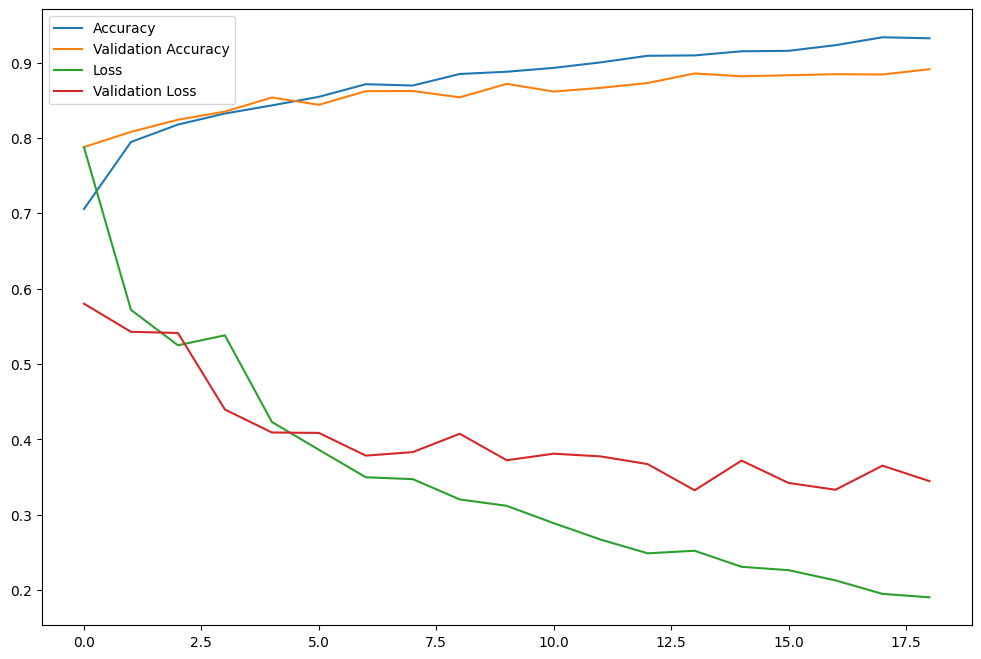

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

350/350 [==============================] - 12s 36ms/step


Text(120.72222222222221, 0.5, 'Truth')

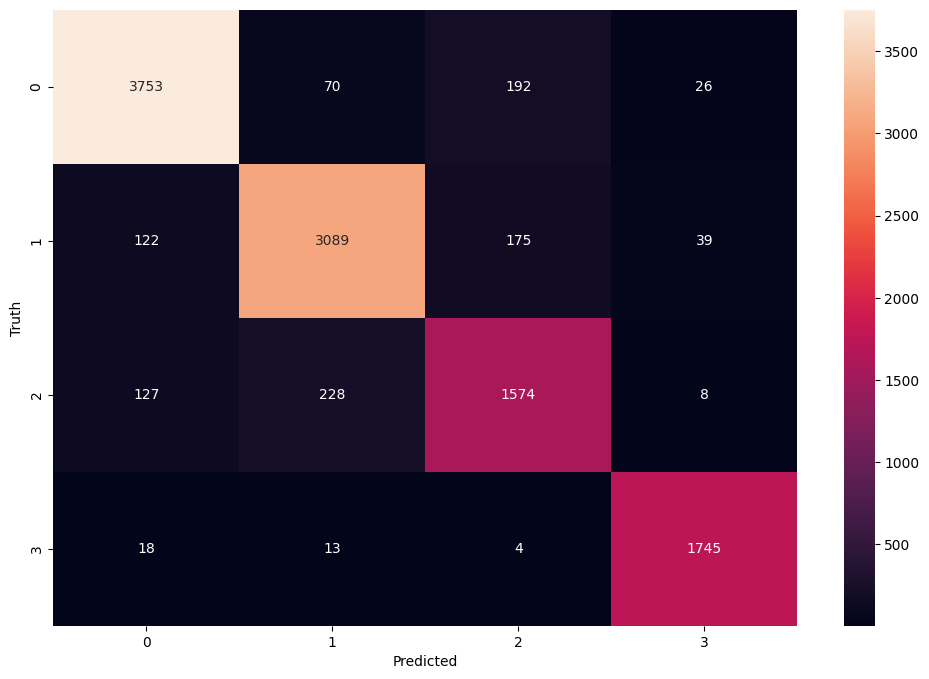

In [22]:
def get_labels(y):
    return ['Lie' if label == 0 else 'Stand' if label == 1 else 'Walk' if label == 2 else 'Sit' for label in y]

y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

y_pred = get_labels(y_pred)
y_test = get_labels(y_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [27]:
classification_report(y_test, y_pred).split("\n")

['              precision    recall  f1-score   support',
 '',
 '           0       0.93      0.93      0.93      4041',
 '           1       0.91      0.90      0.91      3425',
 '           2       0.81      0.81      0.81      1937',
 '           3       0.96      0.98      0.97      1780',
 '',
 '    accuracy                           0.91     11183',
 '   macro avg       0.90      0.91      0.90     11183',
 'weighted avg       0.91      0.91      0.91     11183',
 '']